# 📊 MILK10k Model Evaluation & Metrics Analysis

This notebook provides comprehensive evaluation metrics for the trained MILK10k skin lesion classification model.

## Overview

**Challenge**: ISIC MILK10k Skin Lesion Classification  
**Primary Metric**: Macro F1 Score (threshold ≥ 0.5)  
**Task**: Multi-label classification across 11 diagnosis categories

### Contents
1. **Setup & Model Loading** - Load trained model and validation data
2. **Validation Inference** - Generate predictions on validation set
3. **Core Metrics** - Macro F1, Micro F1, Per-class F1 (ISIC leaderboard style)
4. **Extended Metrics** - Precision, Recall, AUC-ROC, Average Precision
5. **Visualizations** - ROC curves, Confusion matrices, Performance charts
6. **Training History** - Loss curves, F1 progression, Learning rate
7. **Error Analysis** - Misclassified samples, Confidence analysis

---


## 1. Setup & Imports


In [14]:
# Core imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Sklearn metrics
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve,
    multilabel_confusion_matrix, classification_report
)

# Add src to path
sys.path.append('../src')
from config import (
    DIAGNOSIS_CATEGORIES, MODELS_DIR, RESULTS_DIR, 
    PREPROCESSED_DIR, DATASET_DIR, IMAGE_CONFIG, MODEL_CONFIG
)
from models import create_model
from dataset import get_dataloaders, MILK10kDataset
from evaluate import compute_metrics, compute_confusion_matrix
from utils import get_device

# Display settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
%matplotlib inline

print("✅ All imports successful!")
print(f"📦 PyTorch version: {torch.__version__}")
print(f"🔢 CUDA available: {torch.cuda.is_available()}")


✅ All imports successful!
📦 PyTorch version: 2.5.1+cu121
🔢 CUDA available: True


In [15]:
# Constants and full diagnosis names
DIAGNOSIS_FULL_NAMES = {
    'AKIEC': 'Actinic keratosis / Intraepidermal carcinoma',
    'BCC': 'Basal cell carcinoma',
    'BEN_OTH': 'Other benign proliferations',
    'BKL': 'Benign keratinocytic lesion',
    'DF': 'Dermatofibroma',
    'INF': 'Inflammatory and infectious conditions',
    'MAL_OTH': 'Other malignant proliferations',
    'MEL': 'Melanoma',
    'NV': 'Melanocytic nevus',
    'SCCKA': 'Squamous cell carcinoma / Keratoacanthoma',
    'VASC': 'Vascular lesions and hemorrhage'
}

# Category groupings
MALIGNANT_CLASSES = ['AKIEC', 'BCC', 'MAL_OTH', 'MEL', 'SCCKA']
BENIGN_CLASSES = ['BEN_OTH', 'BKL', 'DF', 'NV', 'VASC']
OTHER_CLASSES = ['INF']

# Threshold as per ISIC challenge rules
THRESHOLD = 0.5

print(f"📋 {len(DIAGNOSIS_CATEGORIES)} diagnosis categories")
print(f"🔴 Malignant: {len(MALIGNANT_CLASSES)} classes")
print(f"🟢 Benign: {len(BENIGN_CLASSES)} classes")
print(f"🟠 Other: {len(OTHER_CLASSES)} classes")


📋 11 diagnosis categories
🔴 Malignant: 5 classes
🟢 Benign: 5 classes
🟠 Other: 1 classes


## 2. Load Model & Validation Data


In [16]:
# Get device
device = get_device()

# Load the trained model
MODEL_PATH = MODELS_DIR / 'early_fusion.pth'

print(f"📂 Loading model from: {MODEL_PATH}")

# Create model architecture (must match training)
model = create_model(
    architecture=MODEL_CONFIG['architecture'],
    num_classes=len(DIAGNOSIS_CATEGORIES),
    pretrained=False,  # We'll load weights
    fusion_strategy='early',
    use_metadata=MODEL_CONFIG['use_metadata'],
    metadata_dim=MODEL_CONFIG['metadata_dim'],
    dropout=MODEL_CONFIG['dropout']
)

# Load trained weights
checkpoint = torch.load(MODEL_PATH, map_location=device)

# Handle different checkpoint formats
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Loaded checkpoint from epoch {checkpoint.get('epoch', 'unknown')}")
else:
    model.load_state_dict(checkpoint)
    print("✅ Loaded model weights directly")

model = model.to(device)
model.eval()

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"📊 Total parameters: {total_params:,}")


Using GPU: NVIDIA GeForce MX570
📂 Loading model from: d:\PYTHON\DEEP_LEARNING\notebooks\..\models\early_fusion.pth
✅ Loaded checkpoint from epoch 43
📊 Total parameters: 11,534,763


In [17]:
# Load validation data
val_df = pd.read_csv(PREPROCESSED_DIR / 'val_data.csv')
print(f"✅ Loaded validation data: {len(val_df):,} samples")

# Display class distribution in validation set
print(f"\n📊 Validation Set Class Distribution:")
val_label_counts = val_df[DIAGNOSIS_CATEGORIES].sum().sort_values(ascending=False)
for cls, count in val_label_counts.items():
    pct = (count / len(val_df)) * 100
    print(f"   {cls}: {count:>4} ({pct:>5.1f}%)")

# Create validation dataloader
from dataset import get_transforms

# get_transforms returns (train_transform, val_transform) tuple
_, val_transform = get_transforms(IMAGE_CONFIG['image_size'], augment=False)

val_dataset = MILK10kDataset(
    df=val_df,
    transform=val_transform,
    fusion_strategy='early',
    use_metadata=MODEL_CONFIG['use_metadata']
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,  # Set to 0 for Windows compatibility
    pin_memory=True
)

print(f"\n✅ Created validation DataLoader: {len(val_loader)} batches")


✅ Loaded validation data: 1,048 samples

📊 Validation Set Class Distribution:
   BCC:  504 ( 48.1%)
   NV:  149 ( 14.2%)
   BKL:  109 ( 10.4%)
   SCCKA:   95 (  9.1%)
   MEL:   90 (  8.6%)
   AKIEC:   61 (  5.8%)
   DF:   10 (  1.0%)
   INF:   10 (  1.0%)
   BEN_OTH:    9 (  0.9%)
   VASC:    9 (  0.9%)
   MAL_OTH:    2 (  0.2%)

✅ Created validation DataLoader: 33 batches


## 3. Run Validation Inference

Generate predictions on the validation set to compute metrics.


In [18]:
@torch.no_grad()
def run_inference(model, dataloader, device):
    """Run inference and collect predictions and targets."""
    model.eval()
    
    all_predictions = []
    all_targets = []
    all_probabilities = []
    
    print("Running inference on validation set...")
    
    for batch_idx, batch in enumerate(dataloader):
        if len(batch) == 3:
            images, labels, metadata = batch
            images = images.to(device)
            metadata = metadata.to(device)
            logits = model(images, metadata)
        else:
            images, labels = batch
            images = images.to(device)
            logits = model(images)
        
        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(logits)
        
        all_probabilities.append(probs.cpu().numpy())
        all_targets.append(labels.numpy())
        
        if (batch_idx + 1) % 10 == 0:
            print(f"  Processed {batch_idx + 1}/{len(dataloader)} batches...")
    
    # Concatenate all results
    probabilities = np.concatenate(all_probabilities, axis=0)
    targets = np.concatenate(all_targets, axis=0)
    
    # Binarize predictions at threshold
    predictions = (probabilities >= THRESHOLD).astype(int)
    
    print(f"✅ Inference complete!")
    print(f"   Predictions shape: {predictions.shape}")
    print(f"   Targets shape: {targets.shape}")
    
    return probabilities, predictions, targets

# Run inference
probabilities, predictions, targets = run_inference(model, val_loader, device)


Running inference on validation set...
  Processed 10/33 batches...
  Processed 20/33 batches...
  Processed 30/33 batches...
✅ Inference complete!
   Predictions shape: (1048, 11)
   Targets shape: (1048, 11)


## 4. Core Metrics (ISIC Leaderboard Style)

The primary evaluation metric for the MILK10k challenge is **Macro F1 Score**.


In [19]:
# Calculate core metrics
targets_int = targets.astype(int)

# F1 Scores
macro_f1 = f1_score(targets_int, predictions, average='macro', zero_division=0)
micro_f1 = f1_score(targets_int, predictions, average='micro', zero_division=0)
weighted_f1 = f1_score(targets_int, predictions, average='weighted', zero_division=0)
per_class_f1 = f1_score(targets_int, predictions, average=None, zero_division=0)

# Primary metric display (ISIC style)
print("=" * 60)
print("🏆 ISIC MILK10k EVALUATION METRICS")
print("=" * 60)
print(f"\n📊 PRIMARY METRIC (Leaderboard):")
print(f"   ⭐ Macro F1 Score: {macro_f1:.4f}")
print(f"\n📈 Additional F1 Scores:")
print(f"   Micro F1:    {micro_f1:.4f}")
print(f"   Weighted F1: {weighted_f1:.4f}")

# Per-class F1 scores table
print(f"\n📋 Per-Class F1 Scores:")
print("-" * 50)
print(f"{'Class':<12} {'F1 Score':>10} {'Support':>10}")
print("-" * 50)

class_support = targets_int.sum(axis=0)
for i, cat in enumerate(DIAGNOSIS_CATEGORIES):
    f1 = per_class_f1[i]
    support = int(class_support[i])
    # Color coding based on performance
    if f1 >= 0.5:
        indicator = "🟢"
    elif f1 >= 0.3:
        indicator = "🟡"
    else:
        indicator = "🔴"
    print(f"{indicator} {cat:<10} {f1:>10.4f} {support:>10}")

print("-" * 50)
print(f"{'Average':<12} {macro_f1:>10.4f} {int(class_support.sum()):>10}")
print("=" * 60)


🏆 ISIC MILK10k EVALUATION METRICS

📊 PRIMARY METRIC (Leaderboard):
   ⭐ Macro F1 Score: 0.4689

📈 Additional F1 Scores:
   Micro F1:    0.6874
   Weighted F1: 0.6576

📋 Per-Class F1 Scores:
--------------------------------------------------
Class          F1 Score    Support
--------------------------------------------------
🟡 AKIEC          0.4330         61
🟢 BCC            0.7981        504
🔴 BEN_OTH        0.2000          9
🔴 BKL            0.2519        109
🔴 DF             0.1333         10
🟢 INF            0.6667         10
🔴 MAL_OTH        0.0000          2
🟢 MEL            0.5375         90
🟢 NV             0.7523        149
🟢 SCCKA          0.5854         95
🟢 VASC           0.8000          9
--------------------------------------------------
Average          0.4689       1048


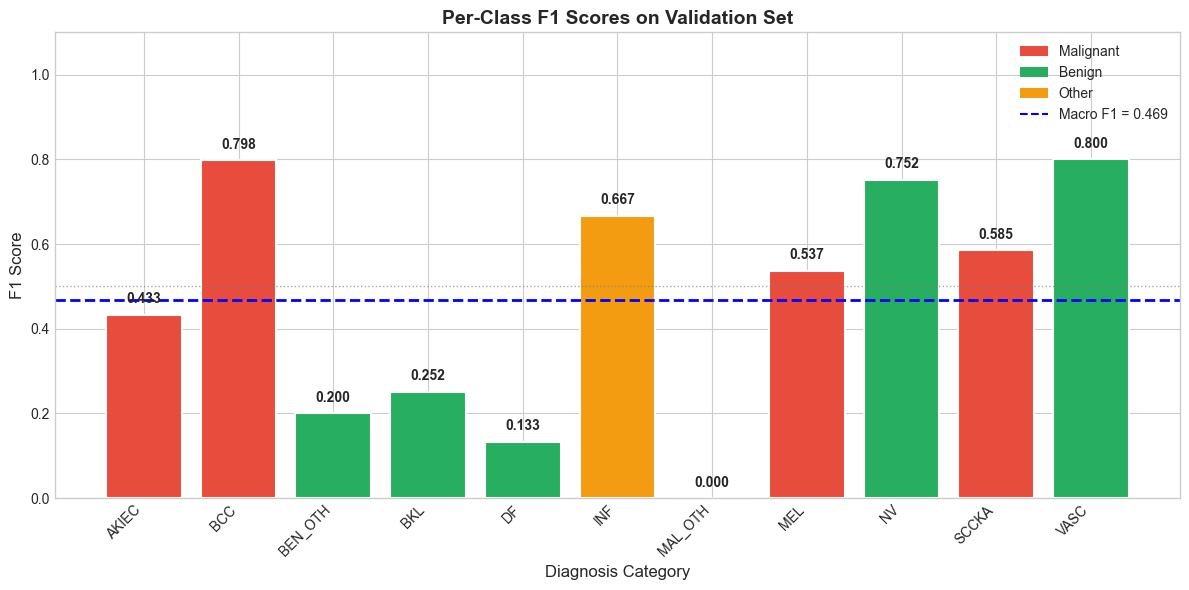

✅ Chart saved to: d:\PYTHON\DEEP_LEARNING\notebooks\..\results\per_class_f1_scores.png


In [20]:
# Visualize per-class F1 scores
fig, ax = plt.subplots(figsize=(12, 6))

# Create bar chart
colors = ['#e74c3c' if cat in MALIGNANT_CLASSES else '#27ae60' if cat in BENIGN_CLASSES else '#f39c12' 
          for cat in DIAGNOSIS_CATEGORIES]

bars = ax.bar(DIAGNOSIS_CATEGORIES, per_class_f1, color=colors, edgecolor='white', linewidth=1.5)

# Add value labels on bars
for bar, f1 in zip(bars, per_class_f1):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{f1:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add horizontal lines for reference
ax.axhline(y=macro_f1, color='blue', linestyle='--', linewidth=2, label=f'Macro F1 = {macro_f1:.3f}')
ax.axhline(y=0.5, color='gray', linestyle=':', linewidth=1, alpha=0.7, label='Threshold = 0.5')

# Styling
ax.set_xlabel('Diagnosis Category', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('Per-Class F1 Scores on Validation Set', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.1)
ax.legend(loc='upper right')

# Rotate x labels
plt.xticks(rotation=45, ha='right')

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', label='Malignant'),
    Patch(facecolor='#27ae60', label='Benign'),
    Patch(facecolor='#f39c12', label='Other')
]
ax.legend(handles=legend_elements + [plt.Line2D([0], [0], color='blue', linestyle='--', label=f'Macro F1 = {macro_f1:.3f}')],
          loc='upper right')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'per_class_f1_scores.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Chart saved to: {RESULTS_DIR / 'per_class_f1_scores.png'}")


## 5. Extended Metrics

Additional metrics including Precision, Recall, AUC-ROC, and Average Precision.


In [21]:
# Calculate extended metrics
# Precision and Recall
macro_precision = precision_score(targets_int, predictions, average='macro', zero_division=0)
macro_recall = recall_score(targets_int, predictions, average='macro', zero_division=0)
micro_precision = precision_score(targets_int, predictions, average='micro', zero_division=0)
micro_recall = recall_score(targets_int, predictions, average='micro', zero_division=0)

per_class_precision = precision_score(targets_int, predictions, average=None, zero_division=0)
per_class_recall = recall_score(targets_int, predictions, average=None, zero_division=0)

# AUC-ROC (requires probabilities)
try:
    macro_auc = roc_auc_score(targets_int, probabilities, average='macro')
    micro_auc = roc_auc_score(targets_int, probabilities, average='micro')
    per_class_auc = roc_auc_score(targets_int, probabilities, average=None)
    auc_available = True
except ValueError as e:
    print(f"⚠️ AUC-ROC calculation issue: {e}")
    auc_available = False

# Average Precision
try:
    macro_ap = average_precision_score(targets_int, probabilities, average='macro')
    micro_ap = average_precision_score(targets_int, probabilities, average='micro')
    per_class_ap = average_precision_score(targets_int, probabilities, average=None)
    ap_available = True
except ValueError as e:
    print(f"⚠️ Average Precision calculation issue: {e}")
    ap_available = False

# Display extended metrics
print("=" * 70)
print("📊 EXTENDED METRICS")
print("=" * 70)

print(f"\n📈 Precision & Recall:")
print(f"   Macro Precision:  {macro_precision:.4f}")
print(f"   Macro Recall:     {macro_recall:.4f}")
print(f"   Micro Precision:  {micro_precision:.4f}")
print(f"   Micro Recall:     {micro_recall:.4f}")

if auc_available:
    print(f"\n📉 AUC-ROC Scores:")
    print(f"   Macro AUC-ROC:    {macro_auc:.4f}")
    print(f"   Micro AUC-ROC:    {micro_auc:.4f}")

if ap_available:
    print(f"\n📊 Average Precision:")
    print(f"   Macro AP:         {macro_ap:.4f}")
    print(f"   Micro AP:         {micro_ap:.4f}")

print("=" * 70)


📊 EXTENDED METRICS

📈 Precision & Recall:
   Macro Precision:  0.6550
   Macro Recall:     0.4107
   Micro Precision:  0.7261
   Micro Recall:     0.6527

📉 AUC-ROC Scores:
   Macro AUC-ROC:    0.8576
   Micro AUC-ROC:    0.9556

📊 Average Precision:
   Macro AP:         0.4937
   Micro AP:         0.7490


In [22]:
# Create comprehensive per-class metrics DataFrame
metrics_data = {
    'Class': DIAGNOSIS_CATEGORIES,
    'F1': per_class_f1,
    'Precision': per_class_precision,
    'Recall': per_class_recall,
    'Support': class_support.astype(int)
}

if auc_available:
    metrics_data['AUC-ROC'] = per_class_auc
if ap_available:
    metrics_data['Avg Precision'] = per_class_ap

metrics_df = pd.DataFrame(metrics_data)
metrics_df['Category'] = metrics_df['Class'].apply(
    lambda x: 'Malignant' if x in MALIGNANT_CLASSES else 'Benign' if x in BENIGN_CLASSES else 'Other'
)

# Sort by F1 score descending
metrics_df = metrics_df.sort_values('F1', ascending=False)

print("\n📋 Complete Per-Class Metrics:")
print(metrics_df.to_string(index=False))

# Save metrics to CSV
metrics_df.to_csv(RESULTS_DIR / 'per_class_metrics.csv', index=False)
print(f"\n✅ Metrics saved to: {RESULTS_DIR / 'per_class_metrics.csv'}")



📋 Complete Per-Class Metrics:
  Class       F1  Precision   Recall  Support  AUC-ROC  Avg Precision  Category
   VASC 0.800000   1.000000 0.666667        9 0.905785       0.717204    Benign
    BCC 0.798095   0.767399 0.831349      504 0.895002       0.873454 Malignant
     NV 0.752294   0.691011 0.825503      149 0.956327       0.812244    Benign
    INF 0.666667   1.000000 0.500000       10 0.897688       0.621252     Other
  SCCKA 0.585366   0.695652 0.505263       95 0.919136       0.608406 Malignant
    MEL 0.537500   0.614286 0.477778       90 0.901473       0.536273 Malignant
  AKIEC 0.432990   0.583333 0.344262       61 0.905327       0.481405 Malignant
    BKL 0.251852   0.653846 0.155963      109 0.803197       0.416747    Benign
BEN_OTH 0.200000   1.000000 0.111111        9 0.909421       0.194703    Benign
     DF 0.133333   0.200000 0.100000       10 0.907129       0.165270    Benign
MAL_OTH 0.000000   0.000000 0.000000        2 0.433556       0.003727 Malignant

✅ Metric

## 6. Visualizations

### 6.1 ROC Curves


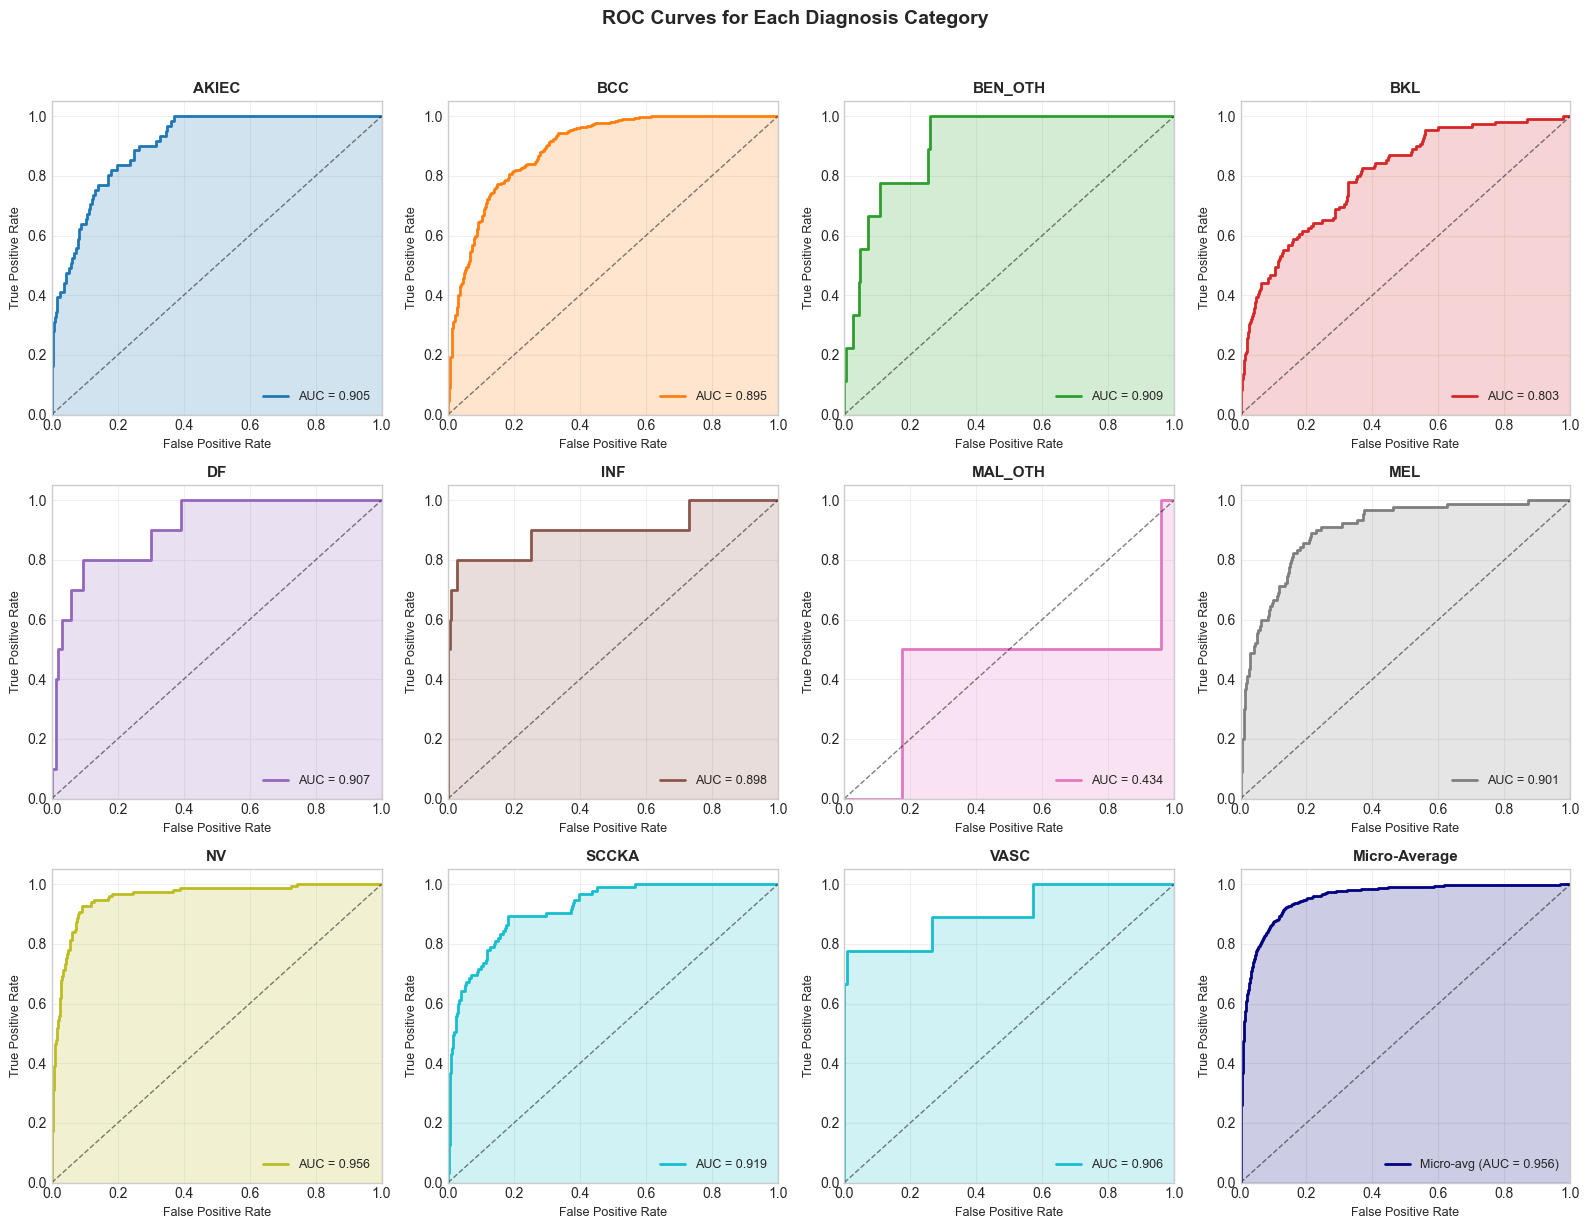

✅ ROC curves saved to: d:\PYTHON\DEEP_LEARNING\notebooks\..\results\roc_curves.png


In [23]:
# Plot ROC curves for each class
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

# Colors for different classes
colors = plt.cm.tab10(np.linspace(0, 1, 11))

# Plot individual ROC curves
for i, cat in enumerate(DIAGNOSIS_CATEGORIES):
    ax = axes[i]
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(targets_int[:, i], probabilities[:, i])
    auc_score = per_class_auc[i] if auc_available else 0
    
    # Plot
    ax.plot(fpr, tpr, color=colors[i], linewidth=2, label=f'AUC = {auc_score:.3f}')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)
    ax.fill_between(fpr, tpr, alpha=0.2, color=colors[i])
    
    # Styling
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=9)
    ax.set_ylabel('True Positive Rate', fontsize=9)
    ax.set_title(f'{cat}', fontsize=11, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)

# Use last subplot for macro-average
ax = axes[11]
# Compute micro-average ROC
fpr_micro, tpr_micro, _ = roc_curve(targets_int.ravel(), probabilities.ravel())
ax.plot(fpr_micro, tpr_micro, color='navy', linewidth=2, 
        label=f'Micro-avg (AUC = {micro_auc:.3f})' if auc_available else 'Micro-avg')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)
ax.fill_between(fpr_micro, tpr_micro, alpha=0.2, color='navy')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=9)
ax.set_ylabel('True Positive Rate', fontsize=9)
ax.set_title('Micro-Average', fontsize=11, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.suptitle('ROC Curves for Each Diagnosis Category', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ ROC curves saved to: {RESULTS_DIR / 'roc_curves.png'}")


### 6.2 Confusion Matrices

For multi-label classification, we show a 2x2 confusion matrix for each class.


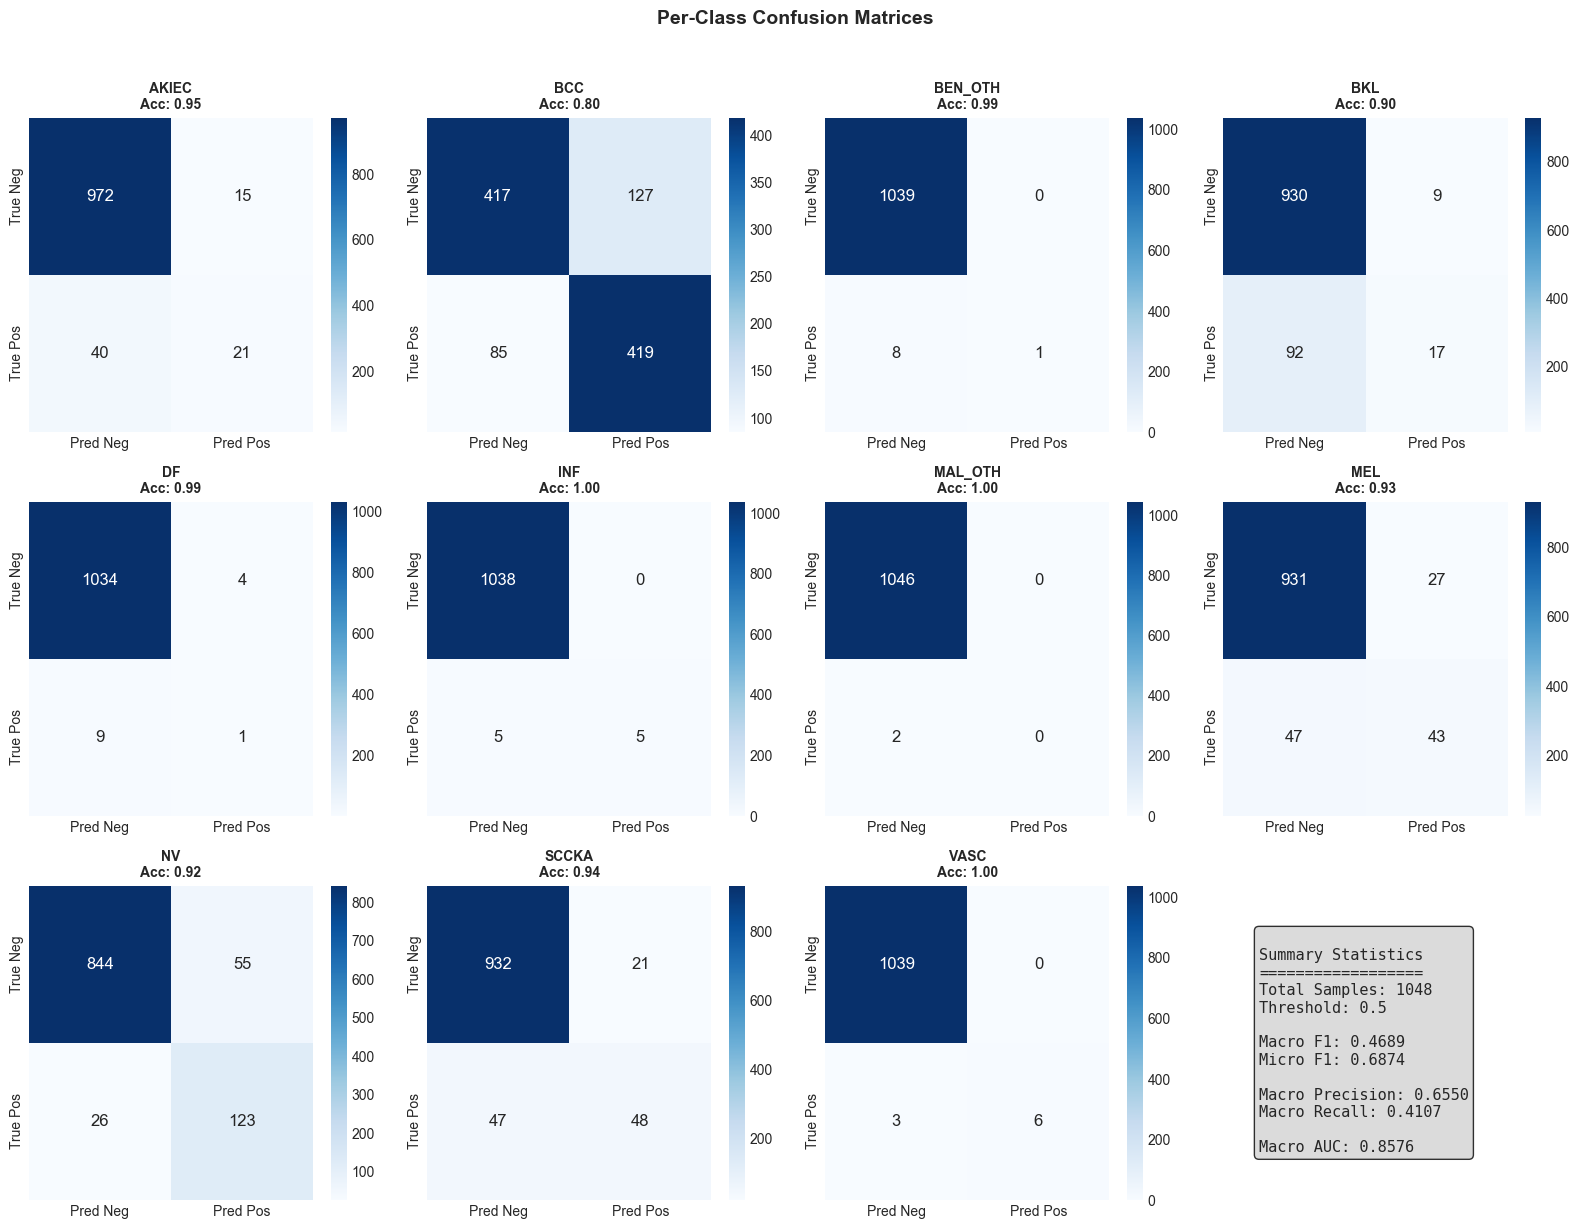

✅ Confusion matrices saved to: d:\PYTHON\DEEP_LEARNING\notebooks\..\results\confusion_matrices.png


In [24]:
# Compute multi-label confusion matrices
cm_multilabel = multilabel_confusion_matrix(targets_int, predictions)

# Plot confusion matrices for each class
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i, cat in enumerate(DIAGNOSIS_CATEGORIES):
    ax = axes[i]
    cm = cm_multilabel[i]
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Pred Neg', 'Pred Pos'],
                yticklabels=['True Neg', 'True Pos'],
                annot_kws={'size': 12})
    
    # Calculate metrics for this class
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    
    ax.set_title(f'{cat}\nAcc: {accuracy:.2f}', fontsize=10, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')

# Summary in last subplot
ax = axes[11]
ax.axis('off')
summary_text = f"""
Summary Statistics
==================
Total Samples: {len(targets_int)}
Threshold: {THRESHOLD}

Macro F1: {macro_f1:.4f}
Micro F1: {micro_f1:.4f}

Macro Precision: {macro_precision:.4f}
Macro Recall: {macro_recall:.4f}
"""
if auc_available:
    summary_text += f"\nMacro AUC: {macro_auc:.4f}"

ax.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
        verticalalignment='center', transform=ax.transAxes,
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.suptitle('Per-Class Confusion Matrices', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Confusion matrices saved to: {RESULTS_DIR / 'confusion_matrices.png'}")


### 6.3 Precision-Recall Comparison


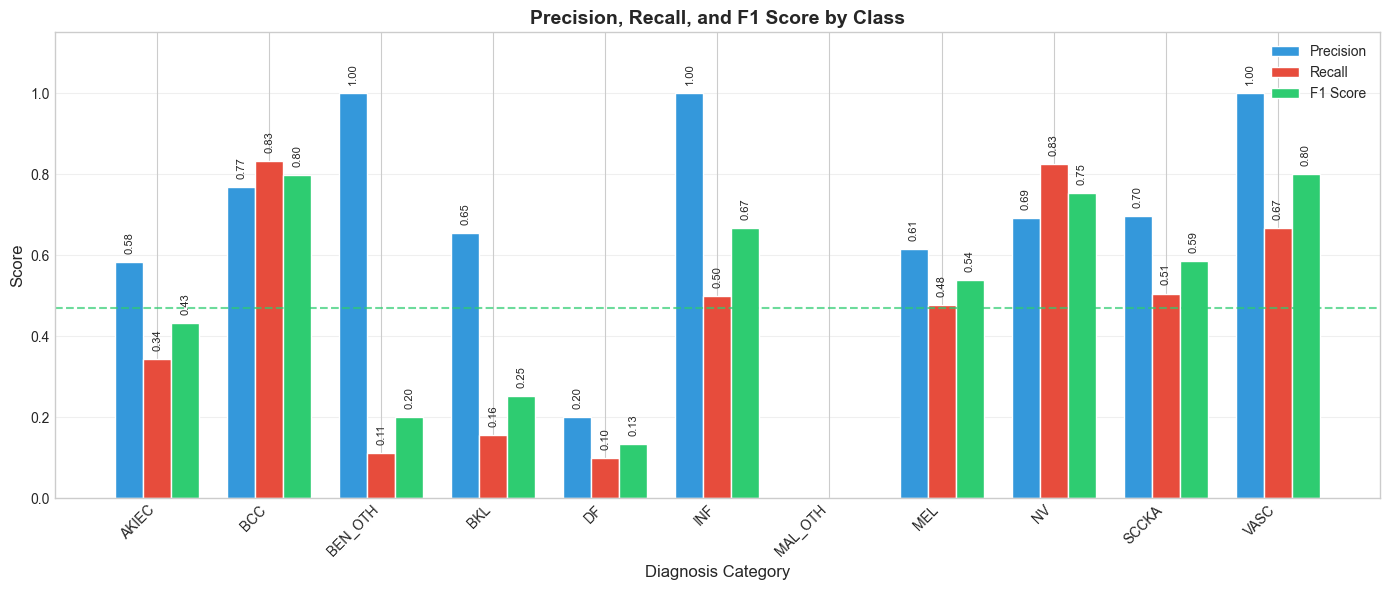

✅ Chart saved to: d:\PYTHON\DEEP_LEARNING\notebooks\..\results\precision_recall_f1.png


In [27]:
# Create precision-recall-F1 comparison chart
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(DIAGNOSIS_CATEGORIES))
width = 0.25

bars1 = ax.bar(x - width, per_class_precision, width, label='Precision', color='#3498db', edgecolor='white')
bars2 = ax.bar(x, per_class_recall, width, label='Recall', color='#e74c3c', edgecolor='white')
bars3 = ax.bar(x + width, per_class_f1, width, label='F1 Score', color='#2ecc71', edgecolor='white')

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if height > 0.05:  # Only show labels for visible bars
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=8, rotation=90)

ax.set_xlabel('Diagnosis Category', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Precision, Recall, and F1 Score by Class', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(DIAGNOSIS_CATEGORIES, rotation=45, ha='right')
ax.legend(loc='upper right')
ax.set_ylim(0, 1.15)
ax.grid(True, alpha=0.3, axis='y')

# Add horizontal line for macro averages
ax.axhline(y=macro_f1, color='#2ecc71', linestyle='--', linewidth=1.5, alpha=0.7)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'precision_recall_f1.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Chart saved to: {RESULTS_DIR / 'precision_recall_f1.png'}")


## 7. Training History Analysis

Visualize training progress including loss curves, F1 score progression, and learning rate schedule.


In [29]:
# Load training history
history_path = MODELS_DIR / 'early_training_history.csv'
history_df = pd.read_csv(history_path)

print(f"✅ Loaded training history: {len(history_df)} epochs")
print(f"\n📊 Training Summary:")
print(f"   Best Macro F1: {history_df['val_f1_macro'].max():.4f} (Epoch {history_df['val_f1_macro'].idxmax() + 1})")
print(f"   Best Micro F1: {history_df['val_f1_micro'].max():.4f}")
print(f"   Final Train Loss: {history_df['train_loss'].iloc[-1]:.4f}")
print(f"   Final Val Loss: {history_df['val_loss'].iloc[-1]:.4f}")


✅ Loaded training history: 59 epochs

📊 Training Summary:
   Best Macro F1: 0.4687 (Epoch 44)
   Best Micro F1: 0.7012
   Final Train Loss: 0.0368
   Final Val Loss: 0.0997


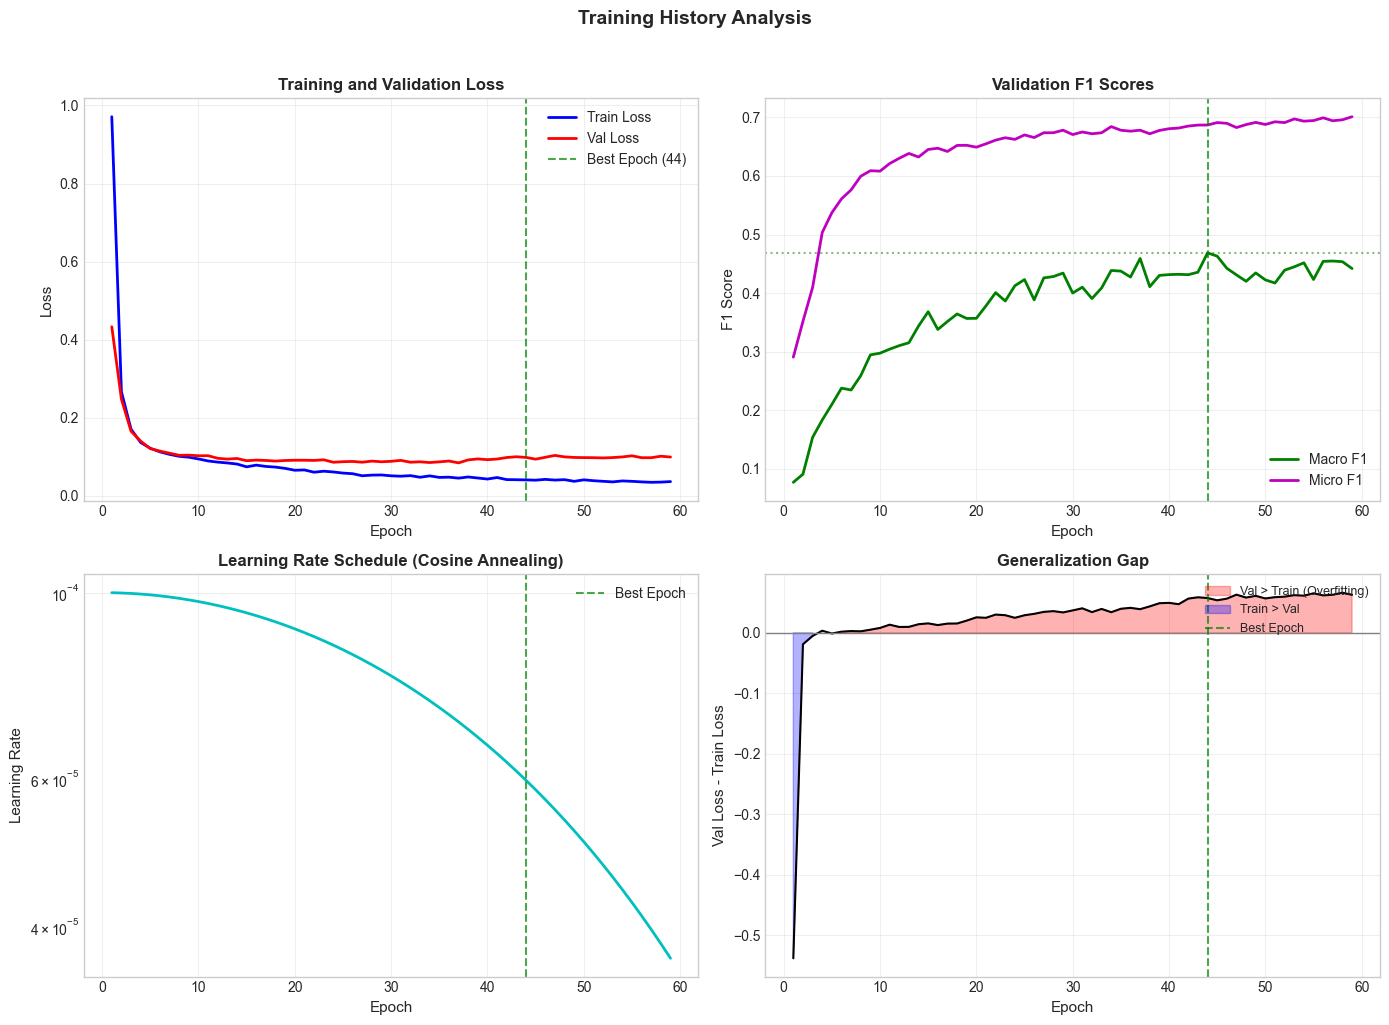

✅ Training curves saved to: d:\PYTHON\DEEP_LEARNING\notebooks\..\results\training_history.png


In [30]:
# Plot comprehensive training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs = range(1, len(history_df) + 1)
best_epoch = history_df['val_f1_macro'].idxmax() + 1

# 1. Loss curves
ax1 = axes[0, 0]
ax1.plot(epochs, history_df['train_loss'], 'b-', linewidth=2, label='Train Loss')
ax1.plot(epochs, history_df['val_loss'], 'r-', linewidth=2, label='Val Loss')
ax1.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Loss', fontsize=11)
ax1.set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# 2. F1 Score curves
ax2 = axes[0, 1]
ax2.plot(epochs, history_df['val_f1_macro'], 'g-', linewidth=2, label='Macro F1')
ax2.plot(epochs, history_df['val_f1_micro'], 'm-', linewidth=2, label='Micro F1')
ax2.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7)
ax2.axhline(y=history_df['val_f1_macro'].max(), color='g', linestyle=':', alpha=0.5)
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('F1 Score', fontsize=11)
ax2.set_title('Validation F1 Scores', fontsize=12, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

# 3. Learning Rate
ax3 = axes[1, 0]
ax3.plot(epochs, history_df['learning_rate'], 'c-', linewidth=2)
ax3.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best Epoch')
ax3.set_xlabel('Epoch', fontsize=11)
ax3.set_ylabel('Learning Rate', fontsize=11)
ax3.set_title('Learning Rate Schedule (Cosine Annealing)', fontsize=12, fontweight='bold')
ax3.set_yscale('log')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Loss Gap (Overfitting indicator)
ax4 = axes[1, 1]
loss_gap = history_df['val_loss'] - history_df['train_loss']
ax4.fill_between(epochs, 0, loss_gap, where=(loss_gap > 0), alpha=0.3, color='red', label='Val > Train (Overfitting)')
ax4.fill_between(epochs, 0, loss_gap, where=(loss_gap <= 0), alpha=0.3, color='blue', label='Train > Val')
ax4.plot(epochs, loss_gap, 'k-', linewidth=1.5)
ax4.axhline(y=0, color='gray', linestyle='-', linewidth=1)
ax4.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best Epoch')
ax4.set_xlabel('Epoch', fontsize=11)
ax4.set_ylabel('Val Loss - Train Loss', fontsize=11)
ax4.set_title('Generalization Gap', fontsize=12, fontweight='bold')
ax4.legend(loc='upper right', fontsize=9)
ax4.grid(True, alpha=0.3)

plt.suptitle('Training History Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Training curves saved to: {RESULTS_DIR / 'training_history.png'}")


## 8. Error Analysis

Analyze model errors including misclassified samples and confidence distributions.


In [31]:
# Analyze prediction confidence
# For each sample, compute the max probability and correctness

# Calculate error types for each class
error_analysis = {}
for i, cat in enumerate(DIAGNOSIS_CATEGORIES):
    y_true = targets_int[:, i]
    y_pred = predictions[:, i]
    y_prob = probabilities[:, i]
    
    # Indices of different error types
    tp_idx = np.where((y_true == 1) & (y_pred == 1))[0]
    tn_idx = np.where((y_true == 0) & (y_pred == 0))[0]
    fp_idx = np.where((y_true == 0) & (y_pred == 1))[0]
    fn_idx = np.where((y_true == 1) & (y_pred == 0))[0]
    
    error_analysis[cat] = {
        'TP': len(tp_idx), 'TN': len(tn_idx), 
        'FP': len(fp_idx), 'FN': len(fn_idx),
        'FP_indices': fp_idx, 'FN_indices': fn_idx,
        'TP_probs': y_prob[tp_idx] if len(tp_idx) > 0 else [],
        'FP_probs': y_prob[fp_idx] if len(fp_idx) > 0 else [],
        'FN_probs': y_prob[fn_idx] if len(fn_idx) > 0 else []
    }

# Summary of errors
print("📊 Error Analysis Summary:")
print("-" * 60)
print(f"{'Class':<10} {'TP':>6} {'TN':>6} {'FP':>6} {'FN':>6} {'Errors':>8}")
print("-" * 60)
for cat in DIAGNOSIS_CATEGORIES:
    ea = error_analysis[cat]
    total_errors = ea['FP'] + ea['FN']
    print(f"{cat:<10} {ea['TP']:>6} {ea['TN']:>6} {ea['FP']:>6} {ea['FN']:>6} {total_errors:>8}")
print("-" * 60)


📊 Error Analysis Summary:
------------------------------------------------------------
Class          TP     TN     FP     FN   Errors
------------------------------------------------------------
AKIEC          21    972     15     40       55
BCC           419    417    127     85      212
BEN_OTH         1   1039      0      8        8
BKL            17    930      9     92      101
DF              1   1034      4      9       13
INF             5   1038      0      5        5
MAL_OTH         0   1046      0      2        2
MEL            43    931     27     47       74
NV            123    844     55     26       81
SCCKA          48    932     21     47       68
VASC            6   1039      0      3        3
------------------------------------------------------------


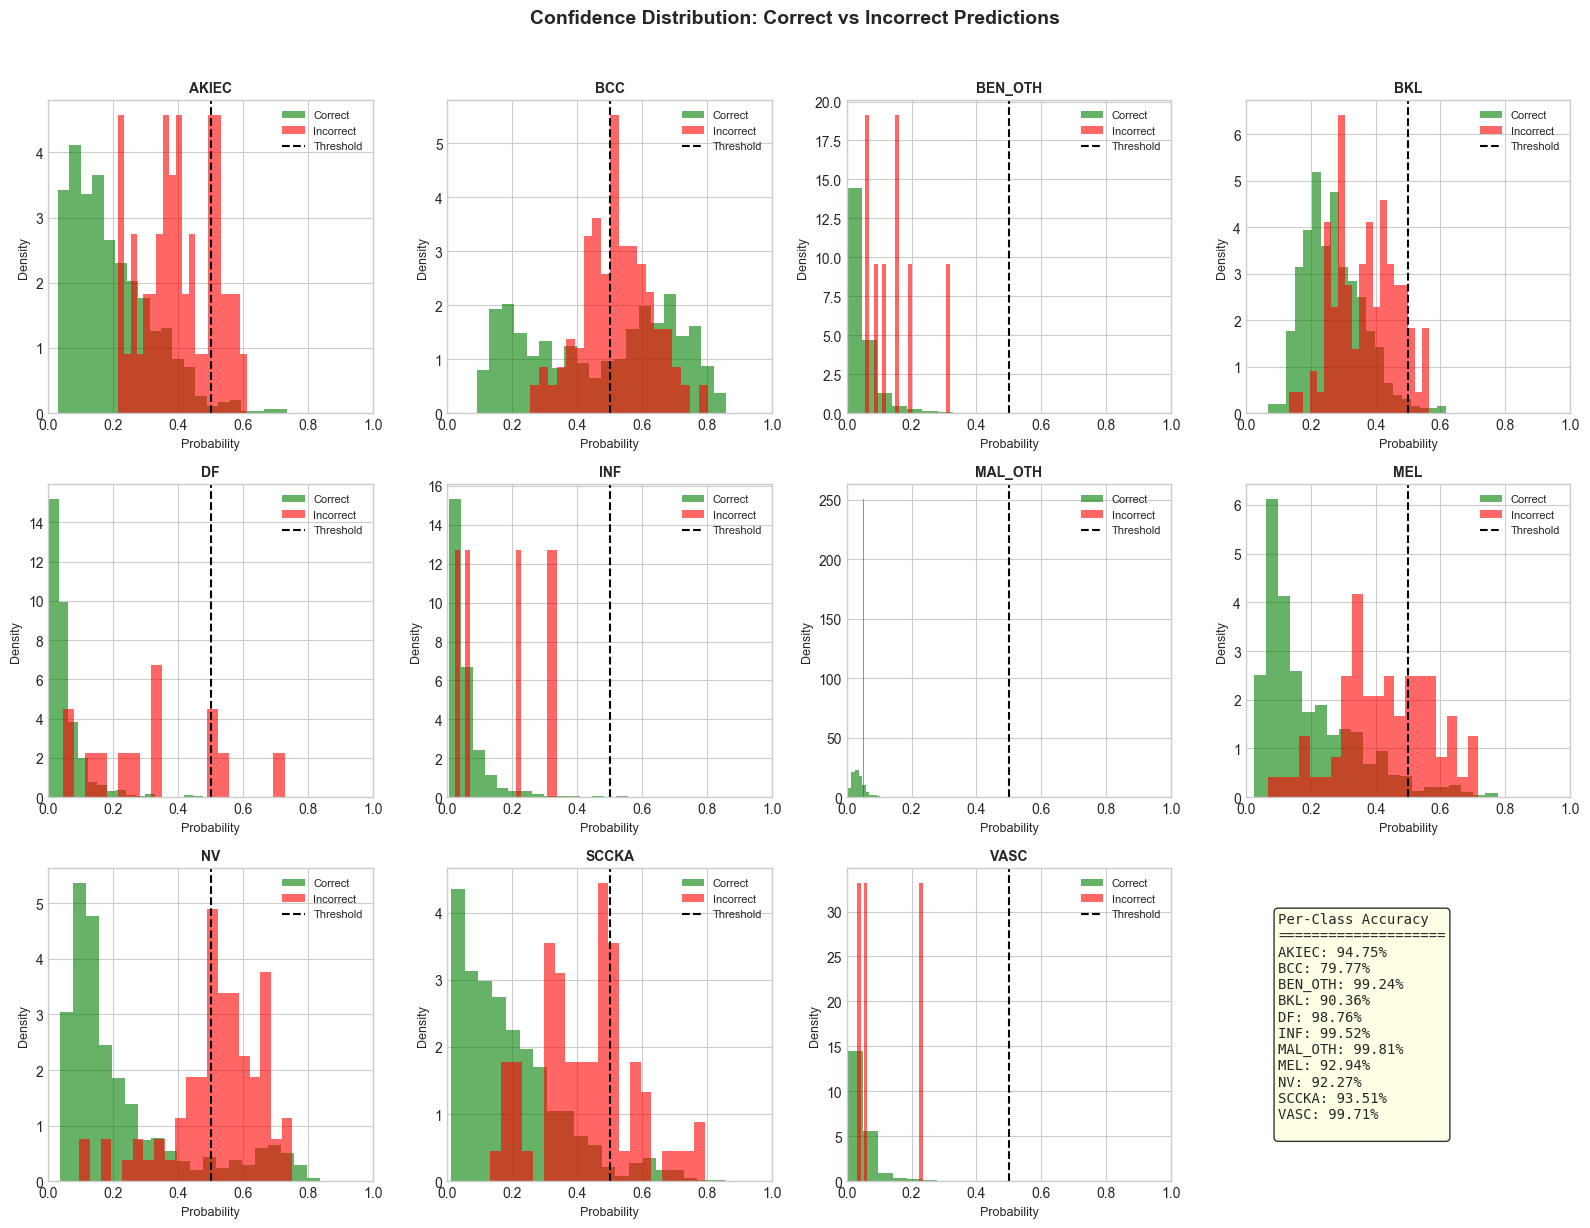

✅ Confidence distributions saved to: d:\PYTHON\DEEP_LEARNING\notebooks\..\results\confidence_distributions.png


In [32]:
# Plot confidence distributions for correct vs incorrect predictions
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i, cat in enumerate(DIAGNOSIS_CATEGORIES):
    ax = axes[i]
    ea = error_analysis[cat]
    
    # Collect probabilities for correct and incorrect predictions
    correct_probs = list(ea['TP_probs']) + list(probabilities[:, i][
        (targets_int[:, i] == 0) & (predictions[:, i] == 0)
    ])
    incorrect_probs = list(ea['FP_probs']) + list(ea['FN_probs'])
    
    # Plot histograms
    if len(correct_probs) > 0:
        ax.hist(correct_probs, bins=20, alpha=0.6, color='green', label='Correct', density=True)
    if len(incorrect_probs) > 0:
        ax.hist(incorrect_probs, bins=20, alpha=0.6, color='red', label='Incorrect', density=True)
    
    ax.axvline(x=THRESHOLD, color='black', linestyle='--', linewidth=1.5, label='Threshold')
    ax.set_xlabel('Probability', fontsize=9)
    ax.set_ylabel('Density', fontsize=9)
    ax.set_title(f'{cat}', fontsize=10, fontweight='bold')
    ax.legend(fontsize=8)
    ax.set_xlim(0, 1)

# Summary plot
ax = axes[11]
ax.axis('off')

# Calculate overall accuracy per class
accuracy_text = "Per-Class Accuracy\n" + "=" * 20 + "\n"
for cat in DIAGNOSIS_CATEGORIES:
    ea = error_analysis[cat]
    acc = (ea['TP'] + ea['TN']) / (ea['TP'] + ea['TN'] + ea['FP'] + ea['FN'])
    accuracy_text += f"{cat}: {acc:.2%}\n"

ax.text(0.1, 0.5, accuracy_text, fontsize=10, family='monospace',
        verticalalignment='center', transform=ax.transAxes,
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.suptitle('Confidence Distribution: Correct vs Incorrect Predictions', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'confidence_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Confidence distributions saved to: {RESULTS_DIR / 'confidence_distributions.png'}")


### 8.1 Sample Misclassified Images

Display examples of false positives and false negatives for selected classes.


📸 Displaying misclassified samples for classes with most errors:




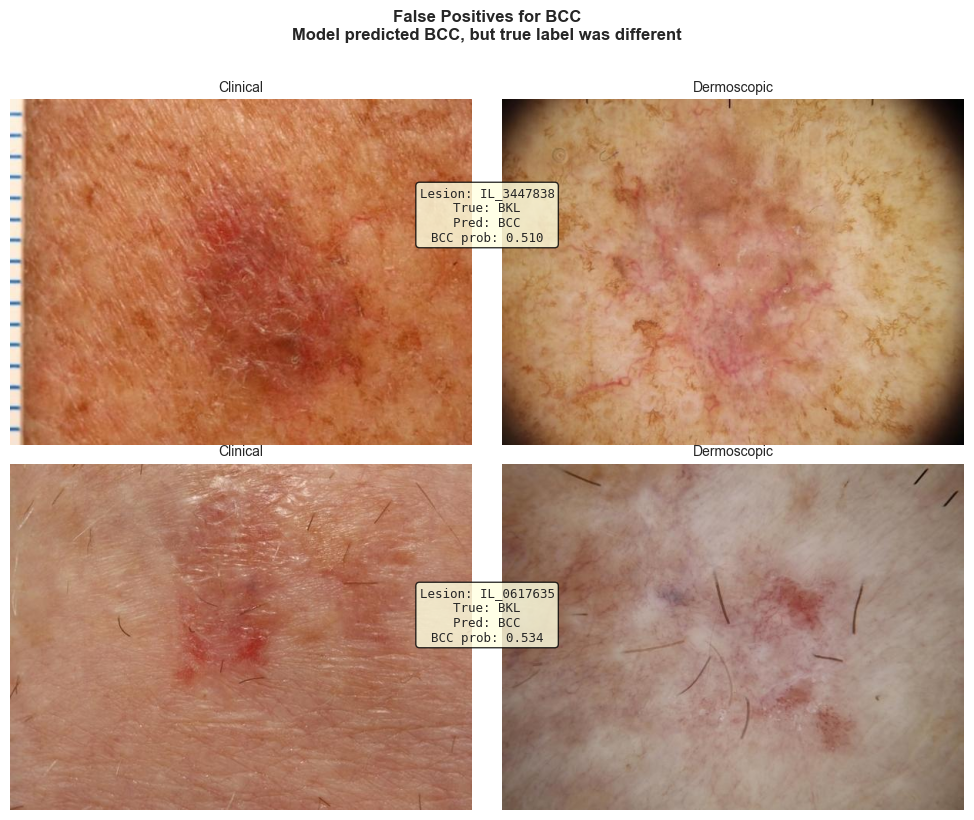

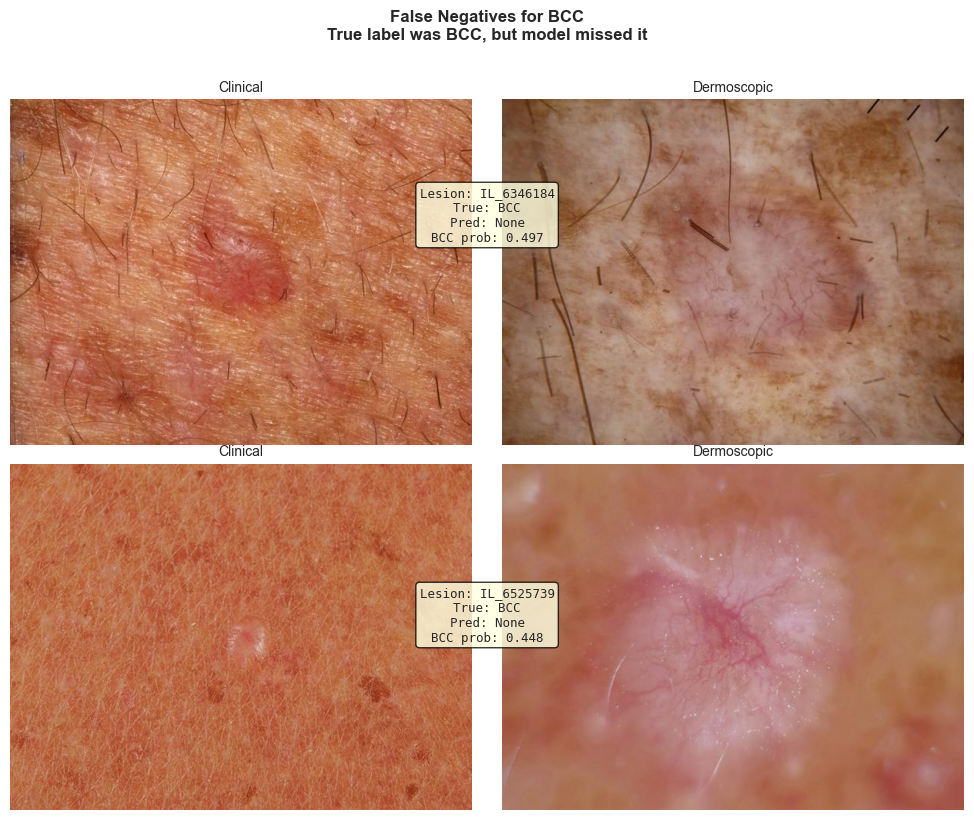

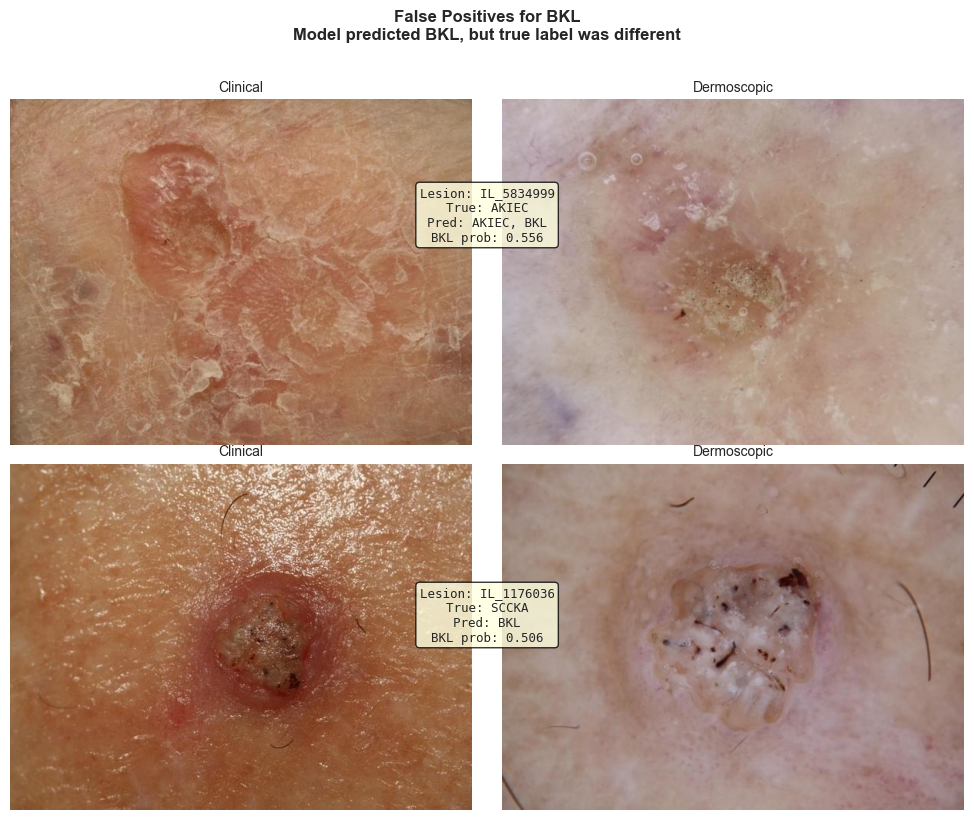

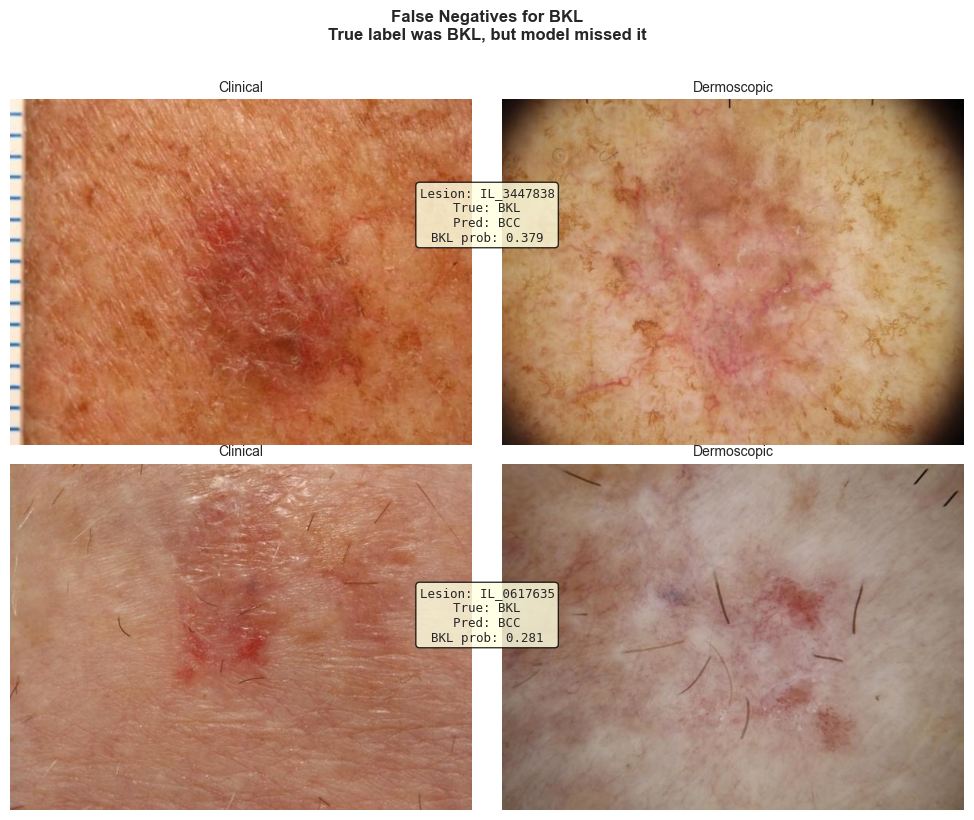

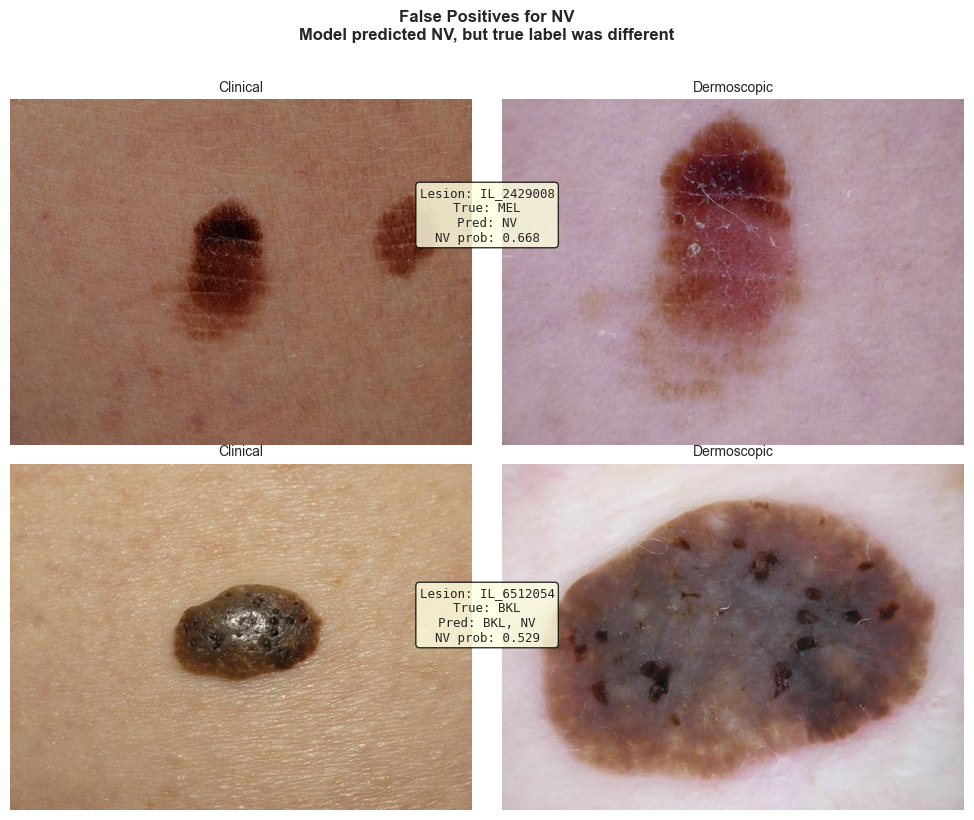

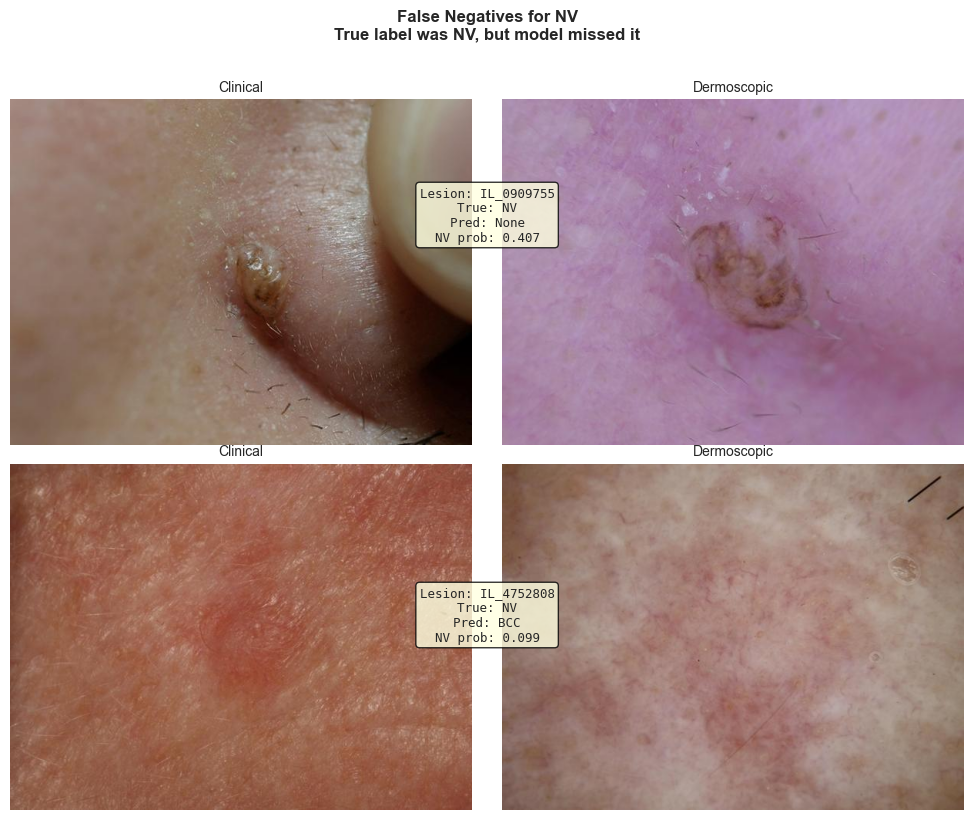

In [33]:
def display_misclassified_samples(val_df, error_analysis, category, error_type='FP', n_samples=4):
    """Display misclassified samples for a given category and error type."""
    
    if error_type == 'FP':
        indices = error_analysis[category]['FP_indices']
        title = f"False Positives for {category}"
        subtitle = f"Model predicted {category}, but true label was different"
    else:  # FN
        indices = error_analysis[category]['FN_indices']
        title = f"False Negatives for {category}"
        subtitle = f"True label was {category}, but model missed it"
    
    if len(indices) == 0:
        print(f"No {error_type} samples for {category}")
        return
    
    # Select samples to display
    sample_indices = indices[:min(n_samples, len(indices))]
    n_display = len(sample_indices)
    
    fig, axes = plt.subplots(n_display, 2, figsize=(10, 4 * n_display))
    if n_display == 1:
        axes = axes.reshape(1, -1)
    
    for idx, sample_idx in enumerate(sample_indices):
        row = val_df.iloc[sample_idx]
        
        # Get image paths
        clinical_path = row['clinical_image_path']
        dermoscopic_path = row['dermoscopic_image_path']
        
        # Get prediction info
        cat_idx = DIAGNOSIS_CATEGORIES.index(category)
        pred_prob = probabilities[sample_idx, cat_idx]
        
        # True labels for this sample
        true_labels = [cat for i, cat in enumerate(DIAGNOSIS_CATEGORIES) if targets_int[sample_idx, i] == 1]
        pred_labels = [cat for i, cat in enumerate(DIAGNOSIS_CATEGORIES) if predictions[sample_idx, i] == 1]
        
        try:
            # Load and display images
            clinical_img = Image.open(clinical_path)
            dermoscopic_img = Image.open(dermoscopic_path)
            
            axes[idx, 0].imshow(clinical_img)
            axes[idx, 0].set_title('Clinical', fontsize=10)
            axes[idx, 0].axis('off')
            
            axes[idx, 1].imshow(dermoscopic_img)
            axes[idx, 1].set_title('Dermoscopic', fontsize=10)
            axes[idx, 1].axis('off')
            
            # Add info text
            info_text = f"Lesion: {row['lesion_id']}\nTrue: {', '.join(true_labels) if true_labels else 'None'}\n"
            info_text += f"Pred: {', '.join(pred_labels) if pred_labels else 'None'}\n{category} prob: {pred_prob:.3f}"
            fig.text(0.5, 1 - (idx + 0.5) / n_display - 0.02, info_text,
                    ha='center', fontsize=9, family='monospace',
                    bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
            
        except Exception as e:
            axes[idx, 0].text(0.5, 0.5, f'Error: {str(e)[:30]}', ha='center', va='center')
            axes[idx, 0].axis('off')
            axes[idx, 1].axis('off')
    
    plt.suptitle(f"{title}\n{subtitle}", fontsize=12, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Display misclassified samples for top classes with errors
classes_with_errors = [(cat, error_analysis[cat]['FP'] + error_analysis[cat]['FN']) 
                       for cat in DIAGNOSIS_CATEGORIES]
classes_with_errors.sort(key=lambda x: x[1], reverse=True)

print("📸 Displaying misclassified samples for classes with most errors:\n")
for cat, n_errors in classes_with_errors[:3]:
    if error_analysis[cat]['FP'] > 0:
        print(f"\n{'='*50}")
        display_misclassified_samples(val_df, error_analysis, cat, 'FP', n_samples=2)
    if error_analysis[cat]['FN'] > 0:
        print(f"\n{'='*50}")
        display_misclassified_samples(val_df, error_analysis, cat, 'FN', n_samples=2)


## 9. Summary & Conclusions


In [35]:
# Generate final summary report
print("=" * 70)
print("📊 MILK10k MODEL EVALUATION REPORT")
print("=" * 70)

print(f"\n🏆 PRIMARY METRIC (ISIC Leaderboard):")
print(f"   Macro F1 Score: {macro_f1:.4f}")

print(f"\n📈 ALL METRICS SUMMARY:")
print(f"   {'Metric':<25} {'Value':>10}")
print(f"   {'-'*35}")
print(f"   {'Macro F1':<25} {macro_f1:>10.4f}")
print(f"   {'Micro F1':<25} {micro_f1:>10.4f}")
print(f"   {'Weighted F1':<25} {weighted_f1:>10.4f}")
print(f"   {'Macro Precision':<25} {macro_precision:>10.4f}")
print(f"   {'Macro Recall':<25} {macro_recall:>10.4f}")
if auc_available:
    print(f"   {'Macro AUC-ROC':<25} {macro_auc:>10.4f}")
if ap_available:
    print(f"   {'Macro Avg Precision':<25} {macro_ap:>10.4f}")

print(f"\n🎯 TOP PERFORMING CLASSES (by F1):")
top_classes = sorted(zip(DIAGNOSIS_CATEGORIES, per_class_f1), key=lambda x: x[1], reverse=True)[:3]
for cat, f1 in top_classes:
    print(f"   {cat}: {f1:.4f}")

print(f"\n⚠️ CHALLENGING CLASSES (lowest F1):")
bottom_classes = sorted(zip(DIAGNOSIS_CATEGORIES, per_class_f1), key=lambda x: x[1])[:3]
for cat, f1 in bottom_classes:
    print(f"   {cat}: {f1:.4f}")

print(f"\n📁 SAVED FILES:")
print(f"   - {RESULTS_DIR / 'per_class_f1_scores.png'}")
print(f"   - {RESULTS_DIR / 'roc_curves.png'}")
print(f"   - {RESULTS_DIR / 'confusion_matrices.png'}")
print(f"   - {RESULTS_DIR / 'precision_recall_f1.png'}")
print(f"   - {RESULTS_DIR / 'training_history.png'}")
print(f"   - {RESULTS_DIR / 'confidence_distributions.png'}")
print(f"   - {RESULTS_DIR / 'per_class_metrics.csv'}")

print("\n" + "=" * 70)
print("✅ Evaluation Complete!")
print("=" * 70)


📊 MILK10k MODEL EVALUATION REPORT

🏆 PRIMARY METRIC (ISIC Leaderboard):
   Macro F1 Score: 0.4689

📈 ALL METRICS SUMMARY:
   Metric                         Value
   -----------------------------------
   Macro F1                      0.4689
   Micro F1                      0.6874
   Weighted F1                   0.6576
   Macro Precision               0.6550
   Macro Recall                  0.4107
   Macro AUC-ROC                 0.8576
   Macro Avg Precision           0.4937

🎯 TOP PERFORMING CLASSES (by F1):
   VASC: 0.8000
   BCC: 0.7981
   NV: 0.7523

⚠️ CHALLENGING CLASSES (lowest F1):
   MAL_OTH: 0.0000
   DF: 0.1333
   BEN_OTH: 0.2000

📁 SAVED FILES:
   - d:\PYTHON\DEEP_LEARNING\notebooks\..\results\per_class_f1_scores.png
   - d:\PYTHON\DEEP_LEARNING\notebooks\..\results\roc_curves.png
   - d:\PYTHON\DEEP_LEARNING\notebooks\..\results\confusion_matrices.png
   - d:\PYTHON\DEEP_LEARNING\notebooks\..\results\precision_recall_f1.png
   - d:\PYTHON\DEEP_LEARNING\notebooks\..\result